In [1]:
import kan

In [2]:
from kan import KAN

model = KAN.loadckpt('/Users/i.grebenkin/Downloads/ram_disk/model/' + '0.1')
# model.get_act(dataset)


In [3]:
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [4]:
import sys
import os
import pickle
import torch

sys.path.append("../../")

from analysis_functions import (
    test_after_opt,
    split_transform_one_comp_cv,
    opener,
    KANModelTrainTest,
)

In [5]:
kan_model = KANModelTrainTest(False)

2025-05-16 16:31:17,916 - INFO - Using device: cpu


In [6]:
kan_model.model = model

In [7]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 2
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


In [8]:
kan_model.create_train_val_test(
    X_current,
    y_current,
)

In [9]:
dir(kan_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_params',
 'best_value',
 'calc_test_metric',
 'calc_validation_metric',
 'create_dataset',
 'create_train_val_test',
 'cur_X_test',
 'cur_y_test',
 'device',
 'get_test_dataset',
 'get_train_dataset',
 'get_val_dataset',
 'input_layer',
 'model',
 'optimize_hyperparams',
 'output_layer',
 'seed',
 'test_input',
 'test_label',
 'train_input',
 'train_label',
 'train_model',
 'train_set_X',
 'train_set_y',
 'val_set_X',
 'val_set_y']

RMSE test with best model: 17.01
MSE test with best model: 289.45
MAE test with best model: 11.95
R2 test with best model: 0.97


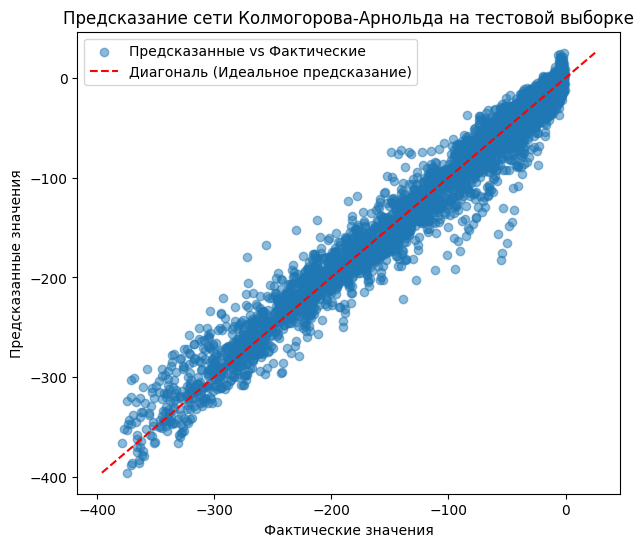

In [14]:
# Визуализация результатов предсказания модели
import matplotlib.pyplot as plt
from analysis_functions import clean_input_array

# Применяем обученную модель к тестовым данным
X_test, y_test, _, _, _, _ = split_transform_one_comp_cv(
    X_current, y_current, n_splits=1
)
X_test, y_test = clean_input_array(X_test, y_test)

# Получаем предсказания

my_dataset = kan_model.create_dataset(
    kan_model.train_set_X[0],
    kan_model.train_set_y[0],
    kan_model.cur_X_test,
    kan_model.cur_y_test,
)
predictions = model(my_dataset["test_input"]).detach().numpy()


# RMSE test with best model: 10.38
# MSE test with best model: 107.82
# MAE test with best model: 5.66
# R2 test with best model: 0.99

# Вычисляем метрики
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)

mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"RMSE test with best model: {rmse:.2f}")
print(f"MSE test with best model: {mse:.2f}")
print(f"MAE test with best model: {mae:.2f}")
print(f"R2 test with best model: {r2:.2f}")


import numpy as np
import matplotlib.pyplot as plt

# Строим график сравнения предсказанных и фактических значений
plt.figure(figsize=(7, 6))
plt.scatter(y_test, predictions, alpha=0.5, label="Предсказанные vs Фактические")

# Добавляем диагональную линию (идеальное предсказание)
min_val = min(np.min(y_test), np.min(predictions))
max_val = max(np.max(y_test), np.max(predictions))
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    label="Диагональ (Идеальное предсказание)",
)

plt.title("Предсказание сети Колмогорова-Арнольда на тестовой выборке")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.legend()
# plt.grid(True)
plt.savefig(f"kan_model_test_prediction_{component_num}.png", dpi=300)
plt.show()


In [11]:
truth = my_dataset["test_label"].detach().numpy()

In [12]:
# kan_errors = rmse(truth, predictions) as vector

kan_errors = np.sqrt(np.mean((truth - predictions) ** 2, axis=1))
kan_errors

array([128.08745  , 115.4646   , 100.83017  , ...,   3.8818798,
         3.2513242,   0.7908571], dtype=float32)

<Axes: ylabel='Density'>

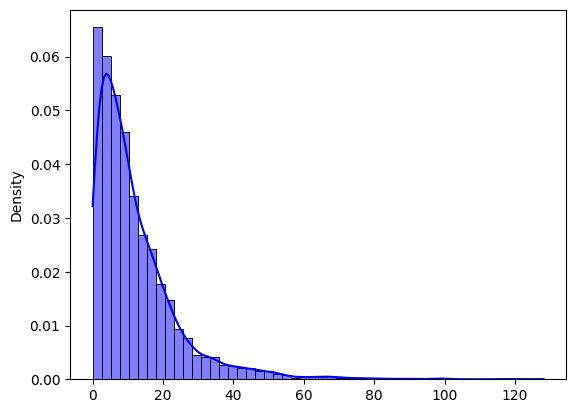

In [13]:
import seaborn as sns

sns.histplot(
    kan_errors,
    bins=50,
    kde=True,
    stat="density",
    color="blue",
    alpha=0.5,
    label="KAN Errors",
)